In [270]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [271]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1")
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1")

In [272]:
train_limpio["text"] = train_limpio["text"].map(lambda x : "null" if(x is None) else x)
test_limpio["text"] = test_limpio["text"].map(lambda x : "null" if(x is None) else x)

In [273]:
train_limpio_true = train_limpio.loc[train_limpio["target"] == 1].sample(frac=1).reset_index(drop=True)
train_limpio_false = train_limpio.loc[train_limpio["target"] == 0].sample(frac=1).reset_index(drop=True)

In [274]:
print("Tenemos {cant_verdaderos: .2f} verdaderos y {cant_falsos: .2f} falsos".format(cant_verdaderos=len(train_limpio_true), cant_falsos=len(train_limpio_false)))

Tenemos  3271.00 verdaderos y  4342.00 falsos


## Voy a balancear el train y el validation, misma cantidad de falsos y verdaderos en ambos

In [275]:
train = pd.concat([train_limpio_true.iloc[:2616], train_limpio_false.iloc[:3473]])
val = pd.concat([train_limpio_true.iloc[2616:3000], train_limpio_false.iloc[3473:3850]])
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[3850:]])

In [276]:
train.head(2)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,wound-keyword,wreck-keyword,wreckag-keyword,isRealPlace,longitud_tweet,letras_seguidas,sentimiento,objetividad,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,50,2,0.0,0.0,fear,NaN
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,110,2,0.0,1.0,quarantin,"Karolinska vÃÂ_gen 18, Solna"


In [277]:
vectorizer = CountVectorizer()
vectorizer.fit(train_limpio["text"].values.astype('U'))

X_train = vectorizer.transform(train["text"].values.astype('U'))
X_val  = vectorizer.transform(val["text"].values.astype('U'))
X_test = vectorizer.transform(test["text"].values.astype('U'))

actual_tp_test_only_text = vectorizer.transform(test_limpio["text"].values.astype('U'))

In [278]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo simple

In [279]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                133800    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 133,811
Trainable params: 133,811
Non-trainable params: 0
_________________________________________________________________


In [280]:
first_history = model.fit(X_train, train["target"].to_numpy(),
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

Epoch 1/100
609/609 [==============================] - 1s 1ms/step - loss: 0.5459 - acc: 0.7573 - val_loss: 0.4599 - val_acc: 0.8016
Epoch 2/100
609/609 [==============================] - 1s 1ms/step - loss: 0.3401 - acc: 0.8675 - val_loss: 0.4493 - val_acc: 0.8108
Epoch 3/100
609/609 [==============================] - 1s 1ms/step - loss: 0.2338 - acc: 0.9177 - val_loss: 0.4780 - val_acc: 0.8042
Epoch 4/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1672 - acc: 0.9433 - val_loss: 0.5220 - val_acc: 0.8055
Epoch 5/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1260 - acc: 0.9557 - val_loss: 0.5707 - val_acc: 0.7989
Epoch 6/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0990 - acc: 0.9658 - val_loss: 0.6121 - val_acc: 0.7924
Epoch 7/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0820 - acc: 0.9711 - val_loss: 0.6730 - val_acc: 0.7924
Epoch 8/100
609/609 [==============================] - 1s 1ms/step - 

609/609 [==============================] - 1s 1ms/step - loss: 0.0280 - acc: 0.9854 - val_loss: 1.7448 - val_acc: 0.7385
Epoch 63/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0275 - acc: 0.9852 - val_loss: 1.7573 - val_acc: 0.7346
Epoch 64/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0272 - acc: 0.9852 - val_loss: 1.7325 - val_acc: 0.7424
Epoch 65/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0273 - acc: 0.9846 - val_loss: 1.7376 - val_acc: 0.7385
Epoch 66/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0272 - acc: 0.9852 - val_loss: 1.7746 - val_acc: 0.7385
Epoch 67/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0274 - acc: 0.9849 - val_loss: 1.7560 - val_acc: 0.7332
Epoch 68/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0272 - acc: 0.9849 - val_loss: 1.7523 - val_acc: 0.7411
Epoch 69/100
609/609 [==============================] - 1s 1ms/step - loss:

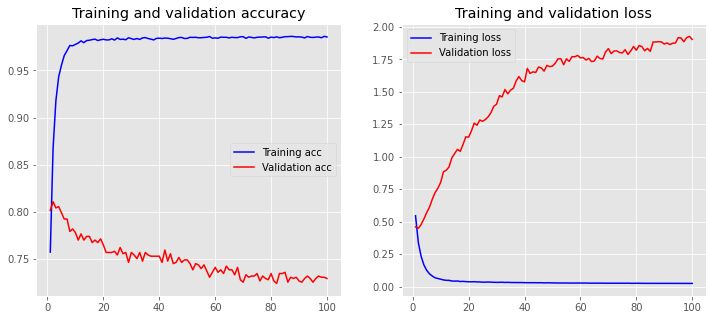

In [281]:
plot_history(first_history)

In [282]:
loss, accuracy = model.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7130


In [283]:
firstPredictions = list(map(lambda x: x[0], model.predict_classes(actual_tp_test_only_text)))

In [284]:
firstPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': firstPredictions})
firstPredictionsDF.head(10)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,1
8,27,0
9,29,1


In [285]:
firstPredictionsDF.to_csv('NN_predictions_first_model.csv', index=False)

## Segundo modelo, agrego ciudades y Tokenizer en vez de count para las words

In [286]:
non_null_locations = train_limpio[train_limpio.location.notnull()]["location"].to_numpy()
non_null_locations

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', ...,
       'Vancouver', 'UK', 'Lincoln'], dtype=object)

In [287]:
encoder = LabelEncoder()
locations = encoder.fit_transform(non_null_locations)
len(locations)

5080

In [288]:
encoder = OneHotEncoder(sparse=False)
locations = locations.reshape((5080, 1))
encoder.fit_transform(locations)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [289]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_limpio["text"].values.astype('U'))

X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_val = tokenizer.texts_to_sequences(val["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_limpio["text"].values[2])
print(X_train[2])

all resid ask to shelter in place are be notifi by offic no other evacu or shelter in place order are expect
[144, 880, 806, 2002, 107, 3517, 727, 3518, 3519]


In [290]:
maxlen = 280

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Pruebo solo texto, modelo mas complejo con maxPooling y mejor embedding

In [291]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 50)           675500    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 676,021
Trainable params: 676,021
Non-trainable params: 0
_________________________________________________________________


In [292]:
second_history = model1.fit(X_train, train["target"].to_numpy(),
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

loss, accuracy = model1.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(second_history)

Testing Accuracy:  0.7693


KeyError: 'acc'